# Introduction

In this project we will perform a sentiment analysis on [data](https://gluebenchmark.com/tasks) from one of GLUE benchmark tasks for natural language processing systems, Stanford Sentiment Treebank (SST-2). This data consists of ~68,000 sentences from movie reviews and annotations of their sentiment – 0 for negative reviews, 1 for positive reviews. We will utilize 3 files from this data to initialize, train, and deploy a machine learning algorithm to classify sentences as positive or negative reviews.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import joblib

# 1.1 Data Processing

Since the files are stored in a zip file, we will manually download the SST-2 data and unzip the folder to access the tsv files. We will then load the data into dataframes. We are doing this first to ensure our data is clean and free of duplicates. In this instance we already know that is the case with this data, but it is still good practice in general when performing data analysis.

In [2]:
train_file = 'train.tsv'
test_file = 'dev.tsv'
eval_file = 'test.tsv'

# create df from tsv file
train_df = pd.read_csv(train_file, sep='\t')
test_df = pd.read_csv(test_file, sep='\t')
eval_df = pd.read_csv(eval_file, sep='\t',index_col=0)

# display df
display(train_df)
display(test_df)
display(eval_df)

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0
...,...,...
867,has all the depth of a wading pool .,0
868,a movie with a real anarchic flair .,1
869,a subject like this should inspire reaction in...,0
870,... is an arthritic attempt at directing by ca...,0


,sentence
index,
0,uneasy mishmash of styles and genres .
1,this film 's relationship to actual tension is...
2,"by the end of no such thing the audience , lik..."
3,director rob marshall went out gunning to make...
4,lathan and diggs have considerable personal ch...
...,...
1816,"it risks seeming slow and pretentious , becaus..."
1817,take care of my cat offers a refreshingly diff...
1818,davis has filled out his cast with appealing f...


# 1.2 Data Analysis

Next we will analyze our data to gain insights into the distribution of positive and negative reviews within and between datasets. We calculate some measurements such as number of positive and negative reviews in each dataset, and average sentence length for positive and negative reviews for each dataset. 

In [3]:
# get count of sentiment distribution
train_values = train_df['label'].value_counts()
test_values = test_df['label'].value_counts()
print(train_values)
print(test_values)

label
1    37569
0    29780
Name: count, dtype: int64
label
1    444
0    428
Name: count, dtype: int64


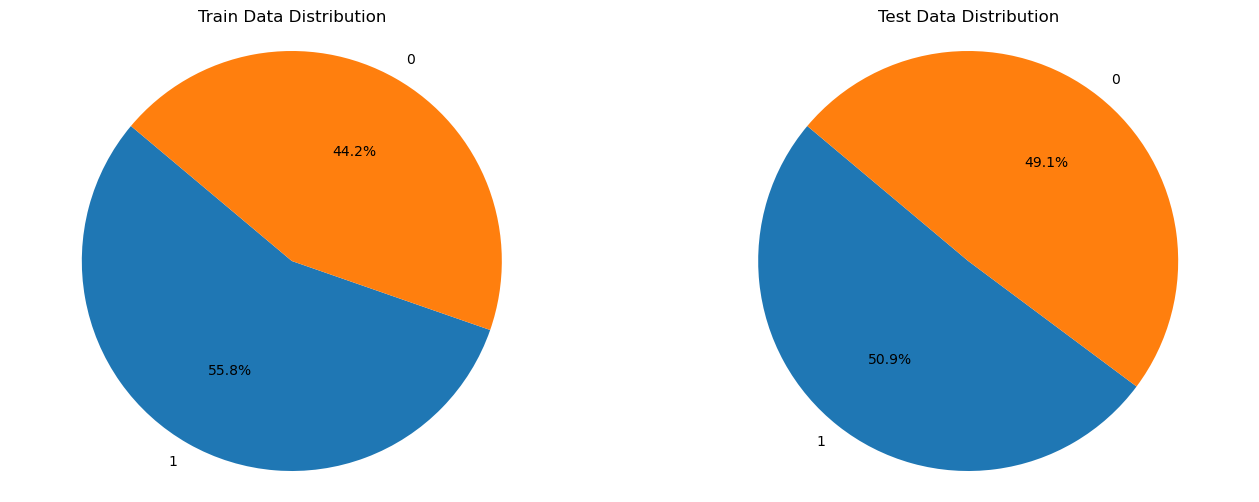

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# chart for training data
axs[0].pie(train_values, labels=train_values.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Train Data Distribution')

# chart for testing data
axs[1].pie(test_values, labels=test_values.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Test Data Distribution')

axs[0].axis('equal')
axs[1].axis('equal')

plt.show()

In [5]:
# calculating distribution of 0 and 1 for each data set
train_classes = train_df['label'].value_counts(normalize=True)
test_classes = test_df['label'].value_counts(normalize=True)

print("Distribution of labels in Training Data:")
print(train_classes)
print("\nDistribution of labels in Testing Data:")
print(test_classes)

Distribution of labels in Training Data:
label
1    0.557826
0    0.442174
Name: proportion, dtype: float64

Distribution of labels in Testing Data:
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64


In [6]:
# getting sentence length for positive and negative reviews for each dataset
train_senLength_0 = train_df[train_df['label'] == 0]['sentence'].apply(lambda x: len(x.split()))
train_senLength_1 = train_df[train_df['label'] == 1]['sentence'].apply(lambda x: len(x.split()))

test_senLength_0 = test_df[test_df['label'] == 0]['sentence'].apply(lambda x: len(x.split()))
test_senLength_1 = test_df[test_df['label'] == 1]['sentence'].apply(lambda x: len(x.split()))

In [7]:
# function to plot histogram and box plot for sentence length data
def plot_histogram_boxplot(data_0, data_1, label_0, label_1, hist_title, box_title):
    hist_0, bins_0 = np.histogram(data_0, bins=50)
    hist_1, bins_1 = np.histogram(data_1, bins=50)

    bar_width = 0.35

    x_0 = bins_0[:-1]
    x_1 = bins_1[:-1] + bar_width  

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.bar(x_0, hist_0, width=bar_width, color='blue', alpha=0.5, label=label_0)
    ax1.bar(x_1, hist_1, width=bar_width, color='red', alpha=0.5, label=label_1)

    ax1.set_xlabel('Sentence Length')
    ax1.set_ylabel('Frequency')
    ax1.set_title(hist_title)
    ax1.legend()

    ax2.boxplot([data_0, data_1], labels=[label_0, label_1])
    ax2.set_yticks(np.arange(0, max(max(data_0), max(data_1)) + 1, 5))

    ax2.set_xlabel('')
    ax2.set_ylabel('Sentence Length')
    ax2.set_title(box_title)

    plt.tight_layout()

    plt.show()

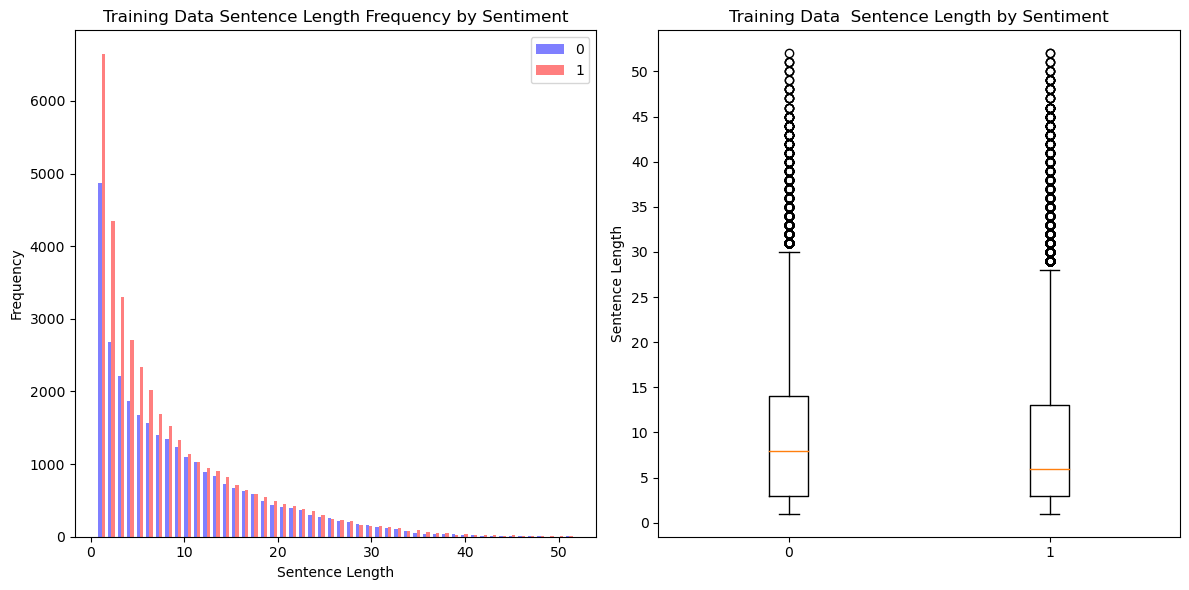

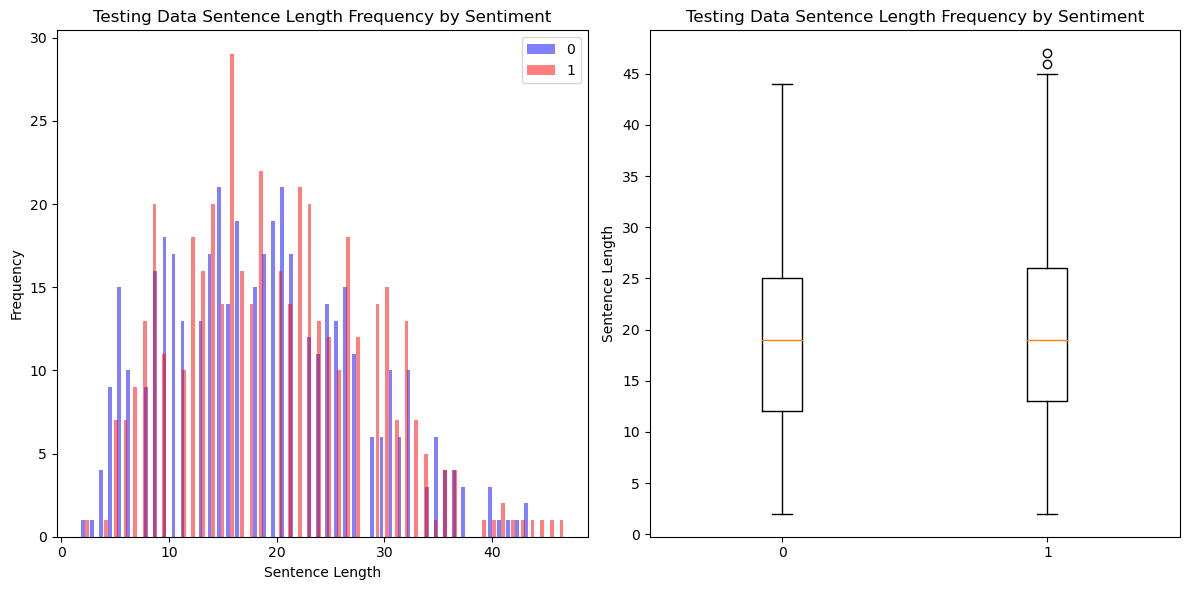

In [8]:
plot_histogram_boxplot(train_senLength_0, train_senLength_1, '0', '1', 'Training Data Sentence Length Frequency by Sentiment', 'Training Data  Sentence Length by Sentiment')
plot_histogram_boxplot(test_senLength_0, test_senLength_1, '0', '1', 'Testing Data Sentence Length Frequency by Sentiment', 'Testing Data Sentence Length Frequency by Sentiment')

# 1.3 Insights

Upon analysis of the distribution of positive and negative reviews in the SST-2 data sets, we find a couple notable differences between the positive and negative reviews within each and across both dataset(s). Firstly, the training dataset contains approximately 56% positive reviews compared to negative, whereas the testing dataset has a more balanced 50/50 distribution. This discrepancy may raise concern due to the potential for biased model training and evaluation. Models trained with this dataset may learn to better recognize positive statements and therefore may struggle to classify a more evenly distributed dataset. 

The second imbalance is seen in the distribution of sentence lengths for positive and negative reviews between the datasets. In the training dataset, sentences are overwhemingly short in length. Here 75% of the sentences are under 15 words long, compared to the testing dataset which has a more even distribution. A model trained on this data may struggle to classify longer, more complex sentences, such as those in the testing dataset. This can have a large impact on the choice of vectorizer as one that is well suited for data with minimal features may perform very well on the training dataset but miss important distinctions that appear in data with more numerous features. 

While the distribution of sentence lengths between datasets is quite different, the distribution of sentence length for positive and negative reviews within each dataset is relatively consistent. This is beneficial as it means that the model will be able to draw more equal comparisons between positive and negative reviews with regards to the number of words used in each review. 

# 2.1 Text Vectorization

In choosing a vectorization method we can first assess our metrics calculated earlier as well as perform a visual inspection of the data. We saw earlier that there are 67,349 rows of data in our training dataset. While this may be seem like a large dataset, it is not very large relatively and far from being considered 'big data'. While this task is sentiment analysis, as we saw earlier the sentence lengths are quite short. Therefore, a vectorization method such as n-gram, while useful for these types of tasks, will likely not make a significant difference in the performance of our model while taking far more computing power. 

Two common vectorizers are Bag-of-Words and Term frequency–inverse document frequency (TF-IDF). Bag-of-words counts how often a word appears in the corpus of text, whereas TF-IDF is a score that measures how important a word is to a text corpus. Both methods measure the frequency of terms in a document, but bag-of-words simply counts the occurrences of each word in a document, whereas TF-IDF also takes into account the frequency across multiple documents and penalizes more common words. Since we are performing sentiment analysis on two relatively small and simple datasets, both of these methods should be sufficient for an ablation study to determine which vectorizer is most suitable. 

# 2.2 Ablation Study

Now that we have determined which vectorization methods we are going to test, we can run an ablation study to determine which has the highest accuracy and should be utilized for our machine learning model selection. We can further diversify our options by testing these methods with and without the removal of stopwords from our data. While stopwords are commonly removed due to their relative insignificance to sentiment and need for additional processing power, they can also provide nuance to a sentence that can change the meaning. Since our dataset is not very large, it's worthwhile to run all four options since it will not take significantly more time.

In [9]:
# ablation study for two vectorizers with and without stopwords
vectorizers = {
    'TF-IDF': TfidfVectorizer(),
    'TF-IDF w/o stop words': TfidfVectorizer(stop_words="english"),
    'Count Vectorizer/BoW': CountVectorizer(),
    'Count Vectorizer/BoW w/o stop words': CountVectorizer(stop_words="english")
}

for description, vectorizer in vectorizers.items():
    print(f'\n{description}\n')
    
    # fit vectorizer on training data
    train_V = vectorizer.fit_transform(train_df['sentence'])  
    
    # transform training and test data
    train_V = vectorizer.transform(train_df['sentence'])  
    test_V = vectorizer.transform(test_df['sentence'])  
    train_y = train_df['label']
    test_y = test_df['label']
    
    # set classifier to test vectorization
    model = MultinomialNB(alpha=0.5).fit(train_V, train_df['label'])  

    print("- Number of features:", train_V.shape[1])  
    print("- Training accuracy:  {:.2%}".format(model.score(train_V, train_y)))
    print("- Test accuracy:      {:.2%}".format(model.score(test_V, test_y)))


TF-IDF

- Number of features: 13774
- Training accuracy:  90.87%
- Test accuracy:      79.82%

TF-IDF w/o stop words

- Number of features: 13491
- Training accuracy:  90.02%
- Test accuracy:      77.41%

Count Vectorizer/BoW

- Number of features: 13774
- Training accuracy:  89.67%
- Test accuracy:      80.39%

Count Vectorizer/BoW w/o stop words

- Number of features: 13491
- Training accuracy:  88.98%
- Test accuracy:      78.10%


# 2.3 Choosing a Vectorization Model

The results of our ablation study show that the Bag-of-Words with stopwords vectorizer performed the best on the test data. This method, however, was not the highest performing model on the training data. While this was the case, we are more concerned with performance on the test data because this is where the machine makes its own decisions on classifications. It's possible that the model performed higher on the training data due to overfitting, which can cause it to make inaccurate generalizations with test data because it has learned to capture patterns that are specific to the training dataset. Therefore, we should continue with the model that performs best on the testing data because that shows the model is making generalizations that can be more widely applied to new datasets. We will create variables to store our vectorized data that we will then use to assess and train our machine learning models.

In [10]:
# select vectorizer with best performance
CountVectorizer_BoW = vectorizers['Count Vectorizer/BoW']

# transform data to use the selected vectorizer
final_train_X = CountVectorizer_BoW.transform(train_df['sentence'])  
final_test_X = CountVectorizer_BoW.transform(test_df['sentence'])  

# 3.1 Choosing a Machine Learning Model

Now that we have determined the best performing text vectorizer, we can run our data through a few machine learning models to determine which will produce the best results. Two models commonly used for sentiment analysis are Logistic Regression and Naive-Bayes. Logistic Regression estimates the probability of an event
occurring based on a given dataset of independent variables. Naive-Bayes calculates the likelihood of a particular class by assuming that all features are independent of each other. We can run both of these models on our vectorized data to see which performs better on the test data. 

For the Logistic Regression, we will specify the 'liblinear' solver since the default solver 'lbfgs' does not allow us to run the number of iterations needed for this data. For Naive-Bayes we will utilize the Multinomial model rather than Gaussian as it is more suitable for classification with discrete features.

In [11]:
# function to run a specified ML model on chosen data
def run_ML_model(model, X_train, y_train, X_test, y_test):
    # initialize model
    trained_model = model.fit(X_train, y_train)
    
    # make predictions on test data
    y_test_pred = trained_model.predict(X_test)
    
    # create classification report
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)
    
    # convert report to df
    report_df = pd.DataFrame(report_dict).transpose()
    
    return trained_model, report_df

In [12]:
# calling function on vectorized data for two ML models
bow_log_model, bow_log_report = run_ML_model(LogisticRegression(solver='liblinear'), final_train_X, train_y, final_test_X, test_y)
bow_NB_model, bow_NB_report = run_ML_model(MultinomialNB(), final_train_X, train_y, final_test_X, test_y)

display('Logistic Regression', bow_log_report)
display('Multinomial Naive-Bayes', bow_NB_report)

'Logistic Regression'

,precision,recall,f1-score,support
0,0.844388,0.773364,0.807317,428.000000
1,0.797917,0.862613,0.829004,444.000000
accuracy,0.818807,0.818807,0.818807,0.818807
macro avg,0.821152,0.817989,0.818161,872.000000
weighted avg,0.820726,0.818807,0.818360,872.000000


'Multinomial Naive-Bayes'

,precision,recall,f1-score,support
0,0.827848,0.764019,0.794654,428.000000
1,0.788260,0.846847,0.816504,444.000000
accuracy,0.806193,0.806193,0.806193,0.806193
macro avg,0.808054,0.805433,0.805579,872.000000
weighted avg,0.807691,0.806193,0.805779,872.000000


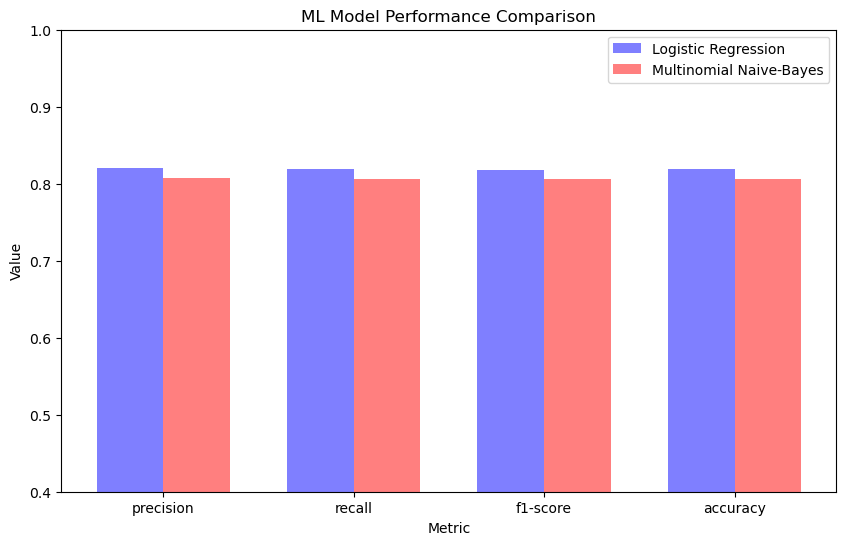

In [13]:
weighted_avg_log_values = bow_log_report.loc['weighted avg'][:3].values
weighted_avg_NB_values = bow_NB_report.loc['weighted avg'][:3].values
accuracy_log = bow_log_report.loc['accuracy', 'precision']
accuracy_NB = bow_NB_report.loc['accuracy', 'precision']

bar_width = 0.35

index = range(len(weighted_avg_log_values))

plt.figure(figsize=(10, 6))

plt.bar(index, weighted_avg_log_values, bar_width, color='blue', alpha=0.5, label='Logistic Regression')
plt.bar([i + bar_width for i in index], weighted_avg_NB_values, bar_width, color='red', alpha=0.5, label='Multinomial Naive-Bayes')

plt.bar(len(index), accuracy_log, bar_width, color='blue', alpha=0.5)
plt.bar(len(index) + bar_width, accuracy_NB, bar_width, color='red', alpha=0.5)

plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('ML Model Performance Comparison')
plt.xticks([i + 0.5 * bar_width for i in index] + [len(index) + 0.5 * bar_width], 
           list(bow_log_report.columns)[:3] + ['accuracy'])
plt.ylim(0.4, 1) 
plt.legend()

# Show plot
plt.show()

# 3.2 Model Performance Analysis

The results of the performance of our two machine learning models are fairly similar. We can assess the perfomance of a model on 4 parameters: Accuracy, Precision, Recall, and F-1 Score. Accuracy refers to the number of correctly predicted data points, precision to the number of true positives divided by the total number of positive predictions, recall to what proportion of actual positives was identified correctly, and F-1 score combines precision and recall to compute how many times a model made a correct prediction across the entire dataset. The Logistic Regression model performed about 2% better on precision, recall, and F-1 score. It also performed about 1% better on accuracy. While these are not large differences, it is still enough to conclude that we should continue with the logistic regression model for this dataset. 

# 4.1 Model Tuning - Hyper-parameter evaluation

Now that we have determined which machine learning model we will use, we can fine-tune the model by evaluating which hyper-parameters produce the highest accuracy. Logistic Regression has a number of hyper-parameters, with the three most commonly utilized being C, penalty, and solver. C refers to regularization strength, penalty to the type of regularization to apply, and solver to the optimization algorithm used to fit the regression model. 

To assess these hyper-parameters, we will run a 5-fold grid search on our training data which will test out numerous combinations of our specified hyper-parameters and return those that produced the greatest accuracy. Penalty and solver only have a handful of options, whereas C can be any positive float. For our grid search we will test a few values in a logarithmic scale starting from .001. For penalty we will use l1 and l2 as these are the options that are compatible with our chosen solvers. Lastly we will test the default lbfgs solver along with liblinear which is a good option for small datasets, and sag which is usually used for larger datasets. 

In [14]:
# choosing classifier
classifier = LogisticRegression()

# view hyperparameters
print('Logistic Regression hyper-parameters\n')
params = classifier.get_params()
for param, default in params.items():
    print(f'... {param:25s}: {default}')
print()

Logistic Regression hyper-parameters

... C                        : 1.0
... class_weight             : None
... dual                     : False
... fit_intercept            : True
... intercept_scaling        : 1
... l1_ratio                 : None
... max_iter                 : 100
... multi_class              : auto
... n_jobs                   : None
... penalty                  : l2
... random_state             : None
... solver                   : lbfgs
... tol                      : 0.0001
... verbose                  : 0
... warm_start               : False



In [15]:
# define hyperparameter range
grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'sag']
}

# perform grid search with folds
gs = GridSearchCV(estimator=bow_log_model, param_grid=grid, cv=5, scoring='accuracy')

# fit grid search to training data
gs.fit(final_train_X, train_y)

# get best hyperparameters and the corresponding model
best_params = gs.best_params_

# print best hyperparameters
print("Best Hyperparameters:", best_params)

/Users/raylesser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/raylesser/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [16]:
# create model using optimized hyperparameters
best_model = LogisticRegression(C=10, penalty='l2', solver='liblinear')
best_model.fit(final_train_X, train_y)

print(f'Best training accuracy {gs.best_score_:.2%}')

y_pred = best_model.predict(final_test_X)

# evaluate  optimized model
test_accuracy = accuracy_score(test_y, y_pred)

print(f'Accuracy on Test Data: {test_accuracy:.2%}')

Best training accuracy 90.65%
Accuracy on Test Data: 80.62%


In [17]:
# create model using optimized hyperparameters
best_model = LogisticRegression(C=.7, penalty='l2', solver='liblinear')
best_model.fit(final_train_X, train_y)

print(f'Best training accuracy {gs.best_score_:.2%}')

y_pred = best_model.predict(final_test_X)

# evaluate  optimized model
test_accuracy = accuracy_score(test_y, y_pred)

print(f'Accuracy on Test Data: {test_accuracy:.2%}')

Best training accuracy 90.65%
Accuracy on Test Data: 82.22%


# 4.2 Grid Search Results and Hyper-parameter Selection

The results of our grid search returned the optimized hyper-parameters of C: 10, penalty: l2, and solver: liblinear. These hyper-parameters returned an accuracy of 80.62% on the testing data. However, after manually exploring some C values I found that there were a few C values that performed better on the test data such as 2 which returned an accuracy of 82.11% and 0.7 which returned 82.22%. I added this value into the grid search and ran it again but it still returned 10 as the optimized number. This is likely due to overfitting, where the model is learning based on patterns that are specific to the training data and is therefore not able to generalize to new data. 

For example, as we discussed earlier the training data is significantly skewed towards short sentences, whereas the testing data has a more even distribution of sentence length. The model may have become very good at correctly identifying the sentiment of sentences that have 15 words or less, but is less able to identify patterns within longer sentences. The training data also has 10% more positive reviews relative to the testing data, so the model will likely become better at identifying positive reviews and therefore have more difficulty classifying the negative reviews in the testing data. 

To continue optimizing this model, we could select more C values to test as well as assess different metrics such as precision, recall, and F-1 score. It is only possible to test two metrics per grid search, so we would need to perform a few grid searches to be able to get all these values. For now we will continue with a C value of 0.7 for our optimized model since this is the manually tested value that produced the highest accuracy on the test data. 

# 5.1 Model Deployment

Now that we have tuned our model, we can deploy it to an evaluation dataset so it an be used to predict the sentiment of reviews in real time. To summarize, our model was trained on  Bag-of-Words vectorized data and utilizes a Logistic Regression model with optimized parameters of C: 0.7, penalty: l2, and solver: liblinear. Rather than simply saving the model in a variable, we will Pickle the vectorizer and model so that they can be saved to disk and utilized in another program or sent over a network. This way both can continue to be utilized outside of this session. 

In [18]:
# store as pkl to call later
joblib.dump(best_model, 'best_model.pkl')
pkl_model = joblib.load('best_model.pkl')

joblib.dump(CountVectorizer_BoW, 'best_vectorizer.pkl')
pkl_vectorizer = joblib.load('best_vectorizer.pkl')

# 5.2 Deployment on Evaluation Set

With our model saved, we can now call it on the evaluation dataset which does not yet contain any labels. First we must vectorize this data, for which we will again use the Bag-of-Words vectorizer. Once the data has been vectorized, we can run our model on it and see what it predicts for each sentence. Unfortunately we do not have labels to compare the results of our model to, but could perform a visual inspection and get a general idea of accuracy based on our own interpretation of the sentiment. We can also manually input sentences to see how the model performs as seen below.

In [19]:
text = pkl_vectorizer.transform(['it is bad', 'it is good', 'it is ok', 'this movie was really great', 'this movie was not as good as it should have been'])
predict = pkl_model.predict(text)
predict

array([0, 1, 1, 1, 0])

In [20]:
# vectorize evaulation data
final_eval_X = pkl_vectorizer.transform(eval_df['sentence'])

# run model on data
predictions = pkl_model.predict(final_eval_X)

# create dataframe for predictions
predictions_df = pd.DataFrame(predictions, columns=['predicted_label'])

# concatenate predicted label with original df
merged_df = pd.concat([eval_df, predictions_df], axis=1)
display(merged_df)

,sentence,predicted_label
0,uneasy mishmash of styles and genres .,0
1,this film 's relationship to actual tension is...,0
2,"by the end of no such thing the audience , lik...",0
3,director rob marshall went out gunning to make...,1
4,lathan and diggs have considerable personal ch...,1
...,...,...
1816,"it risks seeming slow and pretentious , becaus...",0
1817,take care of my cat offers a refreshingly diff...,1
1818,davis has filled out his cast with appealing f...,1
1819,it represents better-than-average movie-making...,0


# 5.3 Discussion

One ethical implication of my solution is the potential reinforcement of biases in film criticism. If the dataset predominantly features reviews from a particular demographic or cultural perspective, my model may learn to prioritize and amplify sentiments aligned with those perspectives, leading to biased predictions. As a result, my model's predictions may reflect and perpetuate existing biases in film criticism and potentially influence audience perceptions and consumption patterns. 

With regard to scientific integrity, my model utilizes standardized benchmark data from a reputable source and with a clear and transparent design, ensuring consistency with other similar models. There is certainly more testing and fine tuning that could be done, but the fact that the GLUE benchmark data is widely used to train models ensures that the data used is in line with community standards. Additionally, there is clear explanation of the design and function of my model, allowing transparency for those seeking to understand my model's design and function. While the data is reputable and used as a benchmark for training, my model should be trained on more substantially diverse datasets before being widely deployed.

A potential unintended consequence of my analysis is incorrect sentiment classification or bias towards reviews by groups that utilize a certain type of language or reference specific movie genres. It may indadvertantly learn to prioritize or favor sentiments expressed by those groups or about those genres, potentially leading to biased predictions. This could result in the marginilization of underrepresented perspectives in the analysis of movie reviews. Additionally, if this model were used in a real-world application such as a movie recommendation tool it could be using biased criteria to influence users' choices, leading to certain movies being overlooked or not recommended to users.

In the broader context of machine learning, technologies such as these have the potential to shape our perceptions, preferences, and behaviors, ultimately influencing cultural trends and societal norms. Especially with regard to sentiment analysis which is a very complex and wide-reaching application of machine learning, it is crucial to recognize the potential for unintended consequences and ethical dilemmas. With subjective data such as this we must ensure we are recognizing the intricacies of human perception and expression in our approach to data collection and analysis.

# Citations

LDSCI7236 Theory and Applications of Data Analytics module materials - Dr. Ioannis Kypraios

Scikit-learn. "sklearn.feature_extraction.text.CountVectorizer." Available online: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Scikit-learn. "sklearn.feature_extraction.text.TfidfVectorizer." Available online: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

FC Lésio. "A Complete Guide to Feature Engineering." Gist GitHub. Available online: https://gist.github.com/fclesio/bb5871281debc07d75127552c56b08b5

Scikit-learn. "sklearn.linear_model.LogisticRegression." Available online: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Scikit-learn. "Naive Bayes." Available online: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

IBM. "Regularization." Available online: https://www.ibm.com/topics/regularization#:~:text=Regularization%20is%20a%20set%20of,overfitting%20in%20machine%20learning%20models.

IBM. "Overfitting." Available online: https://www.ibm.com/topics/overfitting

OpenReview. "Towards Unbiased Models via Normalization of Dataset Labels." Available online: https://openreview.net/pdf?id=rJ4km2R5t7